In [51]:
import pickle, csv, random
import numpy as np
import pandas as pd
import statistics as s
from itertools import product
from math import floor
from tqdm import trange
from scipy.stats import bernoulli
import networkx as nx
from NNetwork import NNetwork as nn
from NNetwork.NNetwork import NNetwork

from sklearn import svm, metrics, model_selection
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.decomposition import PCA ### Use truncated SVD / online PCA later for better computational efficiency
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from karateclub import Graph2Vec, Node2Vec
from SDL.src.SDL_BCD import SDL_BCD

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_graph = pickle.load(open('../data/random_graph/nws_20walk_graph.pkl', 'rb'))
df_dynamics = pd.read_csv("../data/dynamics_pairs/fca_k8_nws_20walk_dynamics.csv")
y = df_dynamics.y
base = df_dynamics.baseline_width
df_dynamics = df_dynamics.loc[:, 's1_1':'s50_20']
df = pd.read_csv("../data/dynamics_pairs/fca_k8_nws_20walk_colored_adj.csv")

In [3]:
# merge true adj and colored adj side by side
scale = 4 # scale down colored adj
X = pd.concat([pd.DataFrame(df_graph.T), df/scale], axis=1)

# SDL on colored adj

In [4]:
Y_data = y
under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(X.values, Y_data)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, 
                                                    test_size = 0.2, 
                                                    random_state = 4, 
                                                    stratify = y_res)

In [5]:
xi = 1
iter_avg = 1
beta = 0.5
iteration = 100
r = 2
SDL_BCD_class_new = SDL_BCD(X=[X_train.T, y_train.to_numpy().reshape(-1,1).T],  # data, label
                        X_test=[X_test.T, y_test.to_numpy().reshape(-1,1).T],
                        #X_auxiliary = None,
                        n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                        # ini_loading=None,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                        # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                        # ini_code = H_true,
                        xi=xi,  # weight on label reconstruction error
                        L1_reg = [0,0,0], # L1 regularizer for code H, dictionary W[0], reg param W[1]
                        L2_reg = [0,0,0], # L2 regularizer for code H, dictionary W[0], reg param W[1]
                        nonnegativity=[True,True,False], # nonnegativity constraints on code H, dictionary W[0], reg params W[1]
                        full_dim=False)

results_dict_new = SDL_BCD_class_new.fit(iter=iteration, subsample_size=None,
                                                beta = beta,
                                                search_radius_const=np.linalg.norm(X_train),
                                                update_nuance_param=False,
                                                if_compute_recons_error=False, if_validate=False)

  0%|          | 0/100 [00:00<?, ?it/s]

initial loading beta [[-0.32840129  0.69613852  0.83729962]]


100%|██████████| 100/100 [09:02<00:00,  5.43s/it]


!!! pred_type filter


In [ ]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
conf_matrix_dynamics = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(conf_matrix_dynamics)
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1: %.3f' % f1_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

In [ ]:
Y_data = y
under_sampler = RandomUnderSampler()
X_res, y_res = under_sampler.fit_resample(pd.concat([df_dynamics, base], axis=1, join='inner').copy(), Y_data)
Y_baseline = X_res.baseline_width
Y_data = y_res

#baseline model
length = len(Y_baseline[Y_baseline==False])
Y_baseline[random.sample(list(Y_baseline[Y_baseline==False].index),length//2)] = True
conf_matrix_baseline = confusion_matrix(y_true=Y_data, y_pred=Y_baseline)
print(conf_matrix_baseline)
print('Precision: %.3f' % precision_score(Y_data, Y_baseline))
print('Recall: %.3f' % recall_score(Y_data, Y_baseline))
print('F1: %.3f' % f1_score(Y_data, Y_baseline))
print('Accuracy: %.3f' % accuracy_score(Y_data, Y_baseline))

In [10]:
results_dict_new

{'xi': 1,
 'L1_reg': [0, 0, 0],
 'L2_reg': [0, 0, 0],
 'nonnegativity': [True, True, False],
 'n_components': 2,
 'loading': [array([[1.62198517e-54, 0.00000000e+00],
         [1.05780202e-02, 1.46507862e-02],
         [2.92322751e-03, 4.80009857e-03],
         ...,
         [4.44911889e-03, 9.29104448e-05],
         [2.88853825e-03, 1.09926718e-04],
         [3.47114165e-53, 0.00000000e+00]]),
  array([[-0.90785475, -0.39845912,  0.69304391]])],
 'code': array([[40.81472858, 27.9736575 , 67.67189283, ..., 59.40696129,
          0.        , 52.54045573],
        [27.45182702, 37.24437509, 25.02804192, ..., 22.92297962,
         56.86900603, 23.41543021]]),
 'iter': 100,
 'dict_update_freq': 1,
 'Training_threshold': 0.5877046606375862,
 'code_test': array([[31.70360856, 39.17917911, 53.34888387, ..., 50.07809425,
         39.47989244, 54.30394691],
        [25.6893913 , 26.42149401, 29.22419223, ..., 30.93168632,
         26.05059242, 29.05458321]]),
 'P_pred': array([[0.98612137],
   

In [ ]:
pickle.dump(results_dict_new, open('temp.pkl', 'wb'))

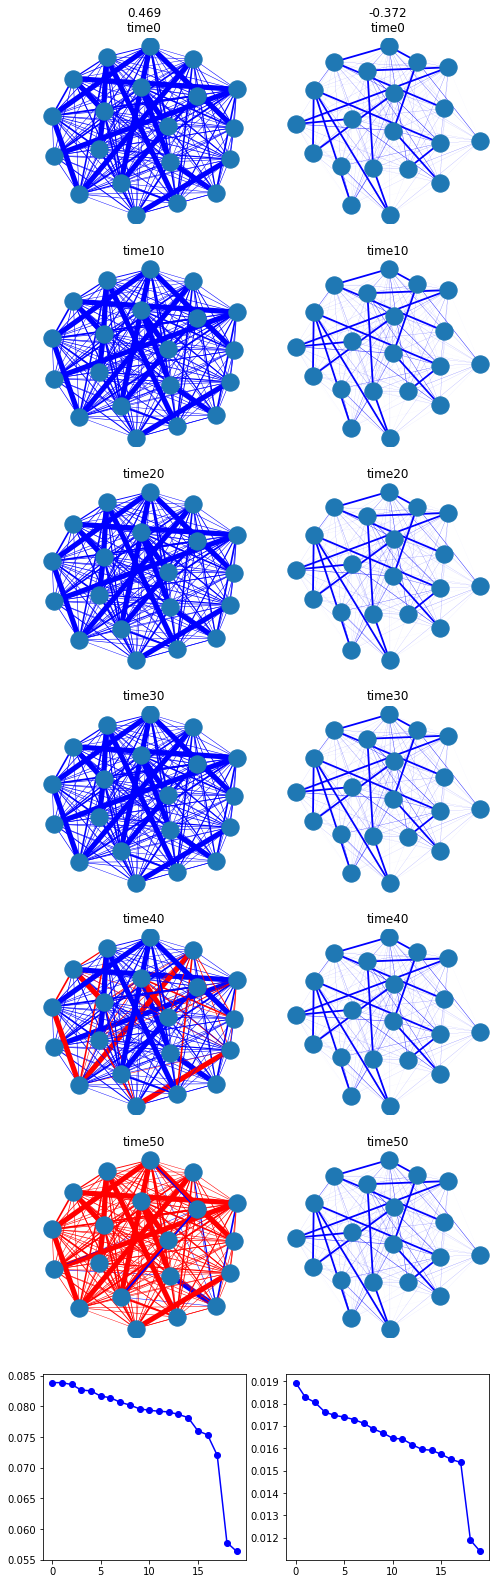

In [6]:
ncol = r
nrow = 6+1
num_nodes = 20
fig, axs = plt.subplots(ncols=ncol, nrows=nrow, figsize=(ncol*4, nrow*4))
sorted_indices = np.argsort(results_dict_new["loading"][1][0][1:])[::-1]
for i in range(ncol):
    ind = sorted_indices[i]
    
    #learned adjacency matrix
    df_adj = pd.DataFrame(results_dict_new["loading"][0].T[ind][0:400].reshape(-1, 20))
    G = nx.from_pandas_adjacency(df_adj)
    edges = G.edges()
    weights = [300*G[u][v]['weight'] for u,v in edges] #weight of learned adjacency matrix
    
    deg_seq = sorted((d for n, d in G.degree(weight='weight')), reverse=True)
    axs[6, i].plot(deg_seq, "b-", marker="o")
        
    
    for j in range(nrow-1):
        col_adj = results_dict_new["loading"][0].T[ind][0+j*10*400:400+j*10*400].reshape(-1, 20)
        
        G1 = nx.Graph()
        for a in range(num_nodes):
            for b in range(num_nodes):
                u = list(G.nodes())[a]
                v = list(G.nodes())[b]
                if G.has_edge(u,v) and u!=v:
                    if col_adj[u, v] == 0: #all synchronizing edges
                        G1.add_edge(u,v, color='r')
                    else:
                        G1.add_edge(u,v, color='b')
        
        edges = G1.edges()
        colors = [G1[u][v]['color'] for u,v in edges]
        nx.draw(G1, edge_color=colors,width=weights, ax=axs[j, i], pos = nx.spring_layout(G1, seed=123))
        
        
        
        #sns.heatmap(results_dict_new["loading"][0].T[ind][0+j*10*400:400+j*10*400].reshape(-1, 20),
                    #ax = axs[j, i])
        if j == 0:
            axs[j, i].title.set_text(str(round(results_dict_new["loading"][1][0][1:][sorted_indices[i]], 3))
                                 +"\ntime"+str(j*10))
        else:
            axs[j, i].title.set_text("time"+str(j*10))

        
    #rect = plt.Rectangle((0.12+i*0.1, 0.12), 0.09, 0.78, fill=False, color="k", lw=1, 
                         #zorder=1000, transform=fig.transFigure, figure=fig)
    #fig.patches.extend([rect])

In [13]:
fig.savefig("temp.jpg")

# <B, WT> examples

In [8]:
df_features = pd.read_csv("../data/random_graph/nws_20walk_graph_features.csv")
results_dict_new = pickle.load(open('../data/dynamics_pairs/fca_k8_nws_20walk_colored_adj_sdl_dict.pkl', 'rb'))
#coef_idx = np.argsort(results_dict_new["loading"][1][0][1:])[::-1] #sorted index for logistic reg coef of dict
#ind = set(base.loc[base==False].index).intersection(y_train.index) #not concentrated index in the training set
#print(df_features.loc[y_train.index, :].num_edges.idxmax())

4005
4005
4005
94
4005
1792


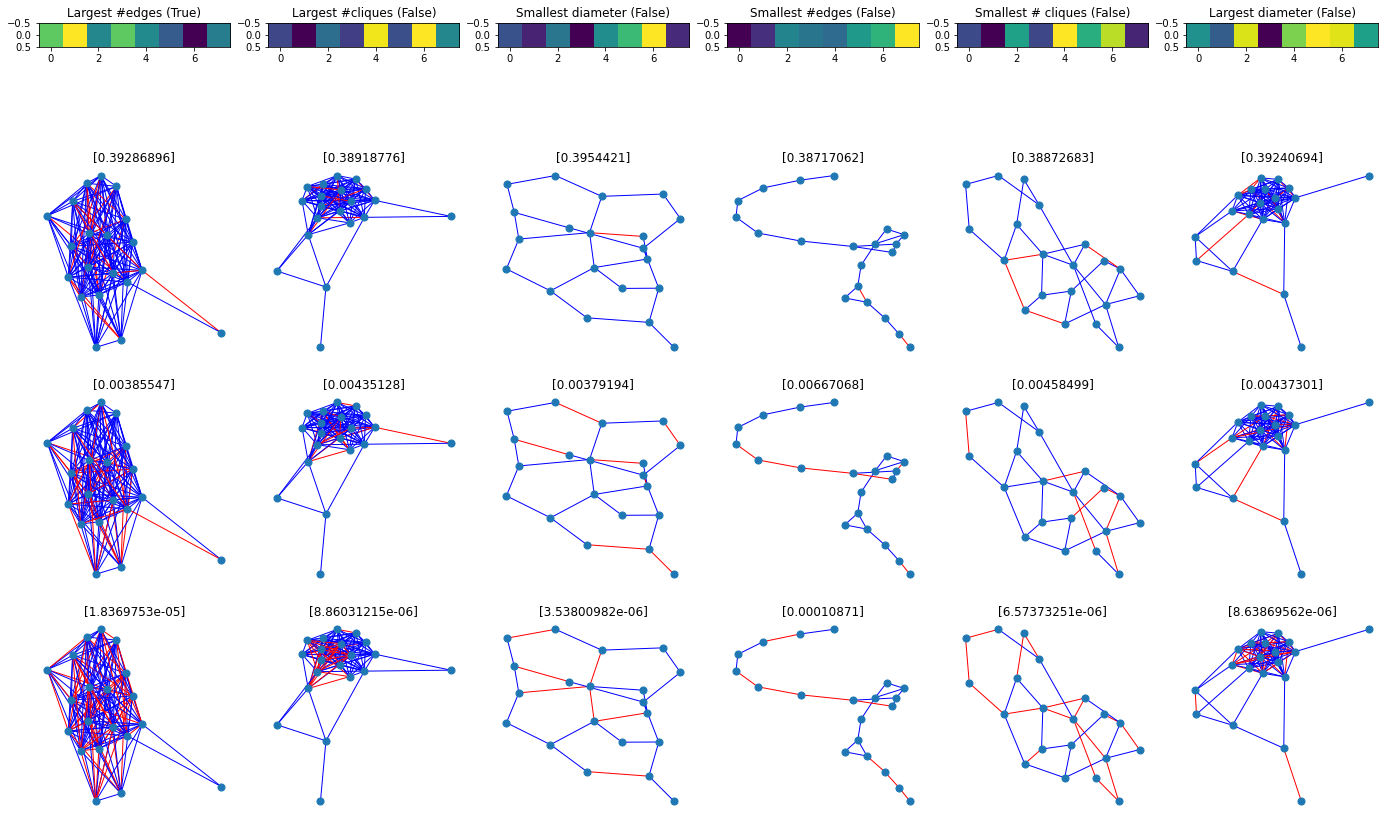

In [50]:
plot_repr_ex(df_features, df_graph,20, results_dict_new, X_train, y_train,
            [1, 20, 50])